# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.


## Preparation

In [1]:
# Loading all the libraries
import pandas as pd
import numpy as np
import warnings
import datetime
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import xgboost as xgb

In [2]:
# to try to open a data file
try:
    data = pd.read_csv('/datasets/taxi.csv',index_col=[0], parse_dates=[0])
except:
    print('Unable to open the files')

In [3]:
# View the first 5 lines
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
# description of the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
# count the number of duplicates
data.duplicated().sum()

26415

In [6]:
data.index.is_monotonic

True

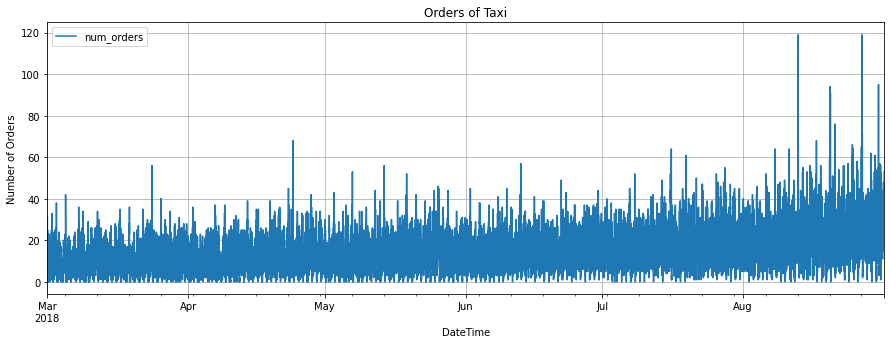

In [7]:
# plot the time series 
data.plot(figsize=(15,5))
plt.xlabel("DateTime")
plt.ylabel("Number of Orders")
plt.title("Orders of Taxi")
plt.grid()
plt.show()

In [8]:
# resample the data by hour
data = data.resample("1H").sum()

### Conclusion

- The data was successfully downloaded and read.
- There are no omissions and duplicates.
- The time series is monotonous.
- The time series is resampled for a convenient period of time.

## Analysis

In [9]:
# average per day
data['rolling_mean'] = data['num_orders'].rolling(24).mean()

In [10]:
# standard deviation per day
data['rolling_sd'] = data['num_orders'].rolling(24).std()

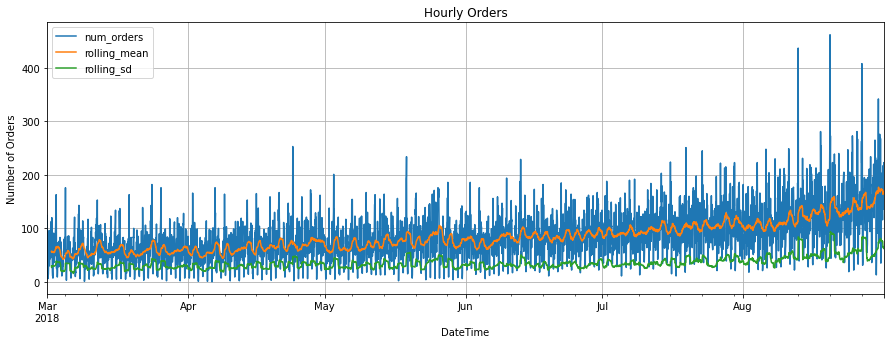

In [11]:
# data behavior
plt.figure(figsize=(15,5))
data.plot(ax=plt.gca())
plt.xlabel("DateTime")
plt.ylabel("Number of Orders")
plt.title('Hourly Orders')
plt.grid()
plt.show()

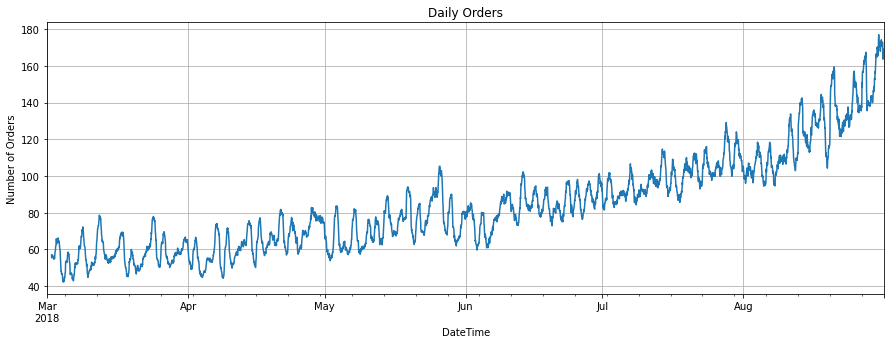

In [12]:
# Average number of taxis in 24 hours
plt.figure(figsize=(15,5))
data['num_orders'].rolling(24).mean().plot(ax=plt.gca())
plt.title('Daily Orders')
plt.xlabel("DateTime")
plt.ylabel("Number of Orders")
plt.grid()
plt.show()


In [13]:
# break the series into trend, seasonality and residuals
decomposed = seasonal_decompose(data['num_orders']['2018-06':'2018-06'])

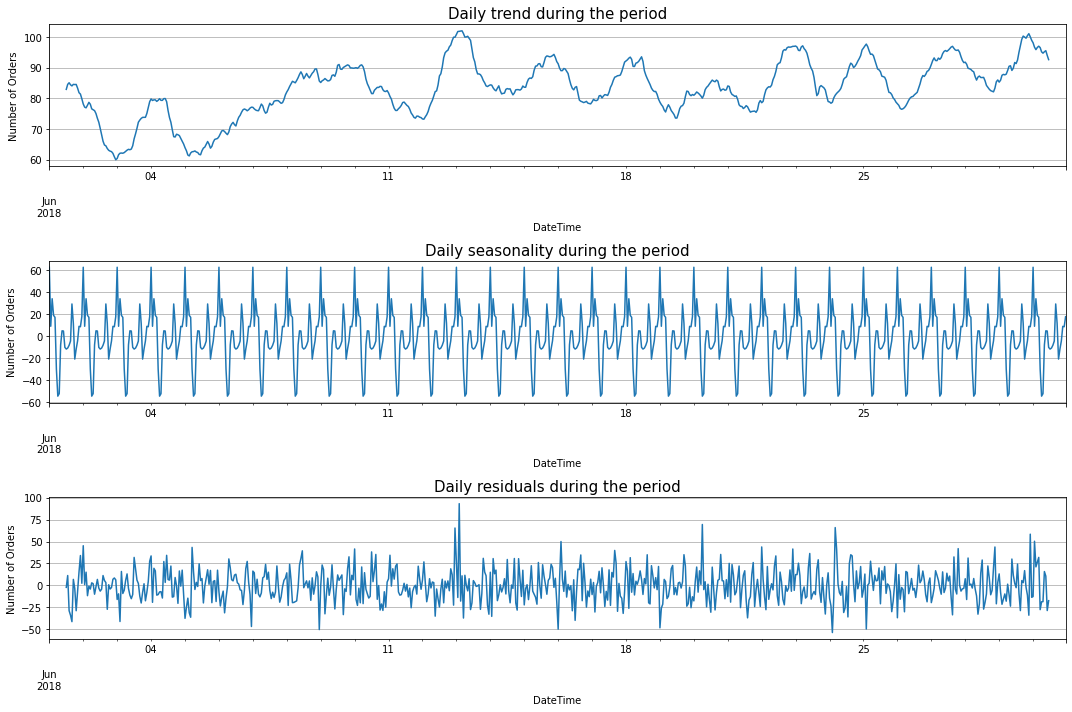

In [14]:
# plot trend, seasonality and residuals
plt.figure(figsize=(15,10))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Daily trend during the period', size=15)
plt.xlabel("DateTime")
plt.ylabel("Number of Orders")
plt.grid()

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Daily seasonality during the period', size=15)
plt.xlabel("DateTime")
plt.ylabel("Number of Orders")
plt.grid()

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Daily residuals during the period', size=15)
plt.xlabel("DateTime")
plt.ylabel("Number of Orders")
plt.grid()

plt.tight_layout()


In [15]:
# checking the series for stationarity
test = adfuller(data['num_orders'])
print('Dickey — Fuller test:', test[0])
print('p-value:', test[1])
print('Critical values:', test[4])
if test[0]> test[4]['5%']: 
    print('The time series is not stationary')
else:
    print('The time series is stationary')

Dickey — Fuller test: -3.0689242890279553
p-value: 0.02894005140261296
Critical values: {'1%': -3.431842162413052, '5%': -2.8621993540813637, '10%': -2.567120978470452}
The time series is stationary


### Conclusion
- The trend graph showed that taxi orders increase over time.
- The seasonality is one day.
- The Dickey-Fuller test showed that the series is stationary.

## Training

In [16]:
# function to create some new features 
def make_features(df, max_lag, rolling_mean_size):
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['hourofday'] = df.index.hour
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    df['rolling_std'] = df['num_orders'].shift().rolling(rolling_mean_size).std()
    

In [17]:
# make new features 
make_features(data, 5, 5)
data.head(10)

,num_orders,rolling_mean,rolling_sd,month,day,dayofweek,hourofday,lag_1,lag_2,lag_3,lag_4,lag_5,rolling_std
datetime,,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,NaN,3,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,NaN,NaN,3,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,NaN,NaN,3,1,3,2,85.0,124.0,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,NaN,NaN,3,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN
2018-03-01 04:00:00,43,NaN,NaN,3,1,3,4,66.0,71.0,85.0,124.0,NaN,NaN
2018-03-01 05:00:00,6,77.8,NaN,3,1,3,5,43.0,66.0,71.0,85.0,124.0,29.928248
2018-03-01 06:00:00,12,54.2,NaN,3,1,3,6,6.0,43.0,66.0,71.0,85.0,30.898220
2018-03-01 07:00:00,15,39.6,NaN,3,1,3,7,12.0,6.0,43.0,66.0,71.0,29.938270
2018-03-01 08:00:00,34,28.4,NaN,3,1,3,8,15.0,12.0,6.0,43.0,66.0,25.383065


In [18]:
# drop NaNs from the time series data
data = data.dropna()
print(data.shape)
data.head()

(4393, 13)


,num_orders,rolling_mean,rolling_sd,month,day,dayofweek,hourofday,lag_1,lag_2,lag_3,lag_4,lag_5,rolling_std
datetime,,,,,,,,,,,,,
2018-03-01 23:00:00,58,71.6,29.409650,3,1,3,23,113.0,66.0,61.0,45.0,73.0,25.333772
2018-03-02 00:00:00,90,68.6,26.730404,3,2,4,0,58.0,113.0,66.0,61.0,45.0,26.005769
2018-03-02 01:00:00,120,77.6,29.250511,3,2,4,1,90.0,58.0,113.0,66.0,61.0,23.458474
2018-03-02 02:00:00,75,89.4,29.345734,3,2,4,2,120.0,90.0,58.0,113.0,66.0,27.509998
2018-03-02 03:00:00,64,91.2,29.322019,3,2,4,3,75.0,120.0,90.0,58.0,113.0,25.839892


In [19]:
# split the data into train and test
train, test = train_test_split(data, shuffle=False, test_size=0.1)

In [20]:
# variables for target and features
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [21]:
# split time series to data samples
tss = TimeSeriesSplit(n_splits=5)

In [22]:
# create empty dictionary for score
ml_stat = dict()

In [23]:
# function to train model using GridSearchSV 

def model_train_pred(model, parm,features_train, target_train, features_test, target_test):
    start = datetime.datetime.now()
    model = GridSearchCV(model, parm, cv=tss, verbose=0, refit=True, scoring='neg_root_mean_squared_error')
    model.fit(features_train, target_train)
    training_time = datetime.datetime.now() - start
    predict = model.predict(features_test)
    rmse = (mean_squared_error(target_test, predict))** .5
    
    print('RMSE:',rmse)
    print('Parameters:',model.best_params_)

    return rmse, training_time

In [24]:
# create the Linear Regression model for sanity check
pipe = Pipeline([
    ('scaling', StandardScaler()),
    ('modelling', LinearRegression())
])

linear_reg = model_train_pred(pipe, {},features_train, target_train, features_test, target_test)

ml_stat['Linear_regression'] = linear_reg

RMSE: 50.131342683545164
Parameters: {}


In [25]:
# create the Random Forest Regression model
pipe = Pipeline([
    ('scaling', StandardScaler()),
    ('modelling', RandomForestRegressor(random_state=12345))
])

random_forest = model_train_pred(pipe, {
                        'modelling__max_depth': [5,10,15,20],
                        'modelling__n_estimators': [25, 50, 75, 100],
                        },
                        features_train, target_train, features_test,target_test)

ml_stat['Random_forest'] = random_forest


RMSE: 45.920165643858006
Parameters: {'modelling__max_depth': 20, 'modelling__n_estimators': 100}


In [26]:
# create the Ridge Regression model
pipe = Pipeline([
    ('scaling', StandardScaler()),
    ('modelling', Ridge())
])

ridge = model_train_pred(pipe, {
                        'modelling__alpha':(0.005 ,0.01, 0.05,0.08, 0.1, 0.5),
                        },
                        features_train, target_train, features_test, target_test)

ml_stat['Ridge'] = ridge

RMSE: 50.13205677096204
Parameters: {'modelling__alpha': 0.5}


In [27]:
#  create the Light GBM Regressor model using encoding categorical features
lightgbm1 = model_train_pred(LGBMRegressor(random_state=12345),
                        {'num_leaves' : range(10, 90, 30),
                        'max_depth' : range(10, 30, 10),
                        }, 
                       features_train, target_train, features_test, target_test)

ml_stat['Light_GBM'] = lightgbm1

RMSE: 44.50347717656425
Parameters: {'max_depth': 10, 'num_leaves': 10}


In [28]:
# create the CatBoost Regressor model
catboost = model_train_pred(CatBoostRegressor(random_state=12345), 
                      {
                        'n_estimators' : range(200, 300, 50),
                        'learning_rate':[0.4],
                        'verbose':[False],
                        'loss_function':['RMSE']}, 
                          features_train, target_train, features_test, target_test)

ml_stat['CatBoost'] = catboost

RMSE: 43.51515156636544
Parameters: {'learning_rate': 0.4, 'loss_function': 'RMSE', 'n_estimators': 200, 'verbose': False}


In [29]:
# create the XGBoost regressor model
xgboost = model_train_pred(xgb.XGBRegressor(random_state=12345), {
                    'n_estimators' : [250],
                    'max_depth' : [20]}, 
                     features_train, target_train, features_test, target_test)

ml_stat['XGBoost'] = xgboost

RMSE: 54.87336388095221
Parameters: {'max_depth': 20, 'n_estimators': 250}


In [30]:
# summary of the models
pd.DataFrame.from_dict(ml_stat, orient='index',columns=['RMSE','Training Time']).sort_values(by='RMSE')

,RMSE,Training Time
CatBoost,43.515152,0 days 00:00:04.963290
Light_GBM,44.503477,0 days 00:00:02.569210
Random_forest,45.920166,0 days 00:01:04.433635
Linear_regression,50.131343,0 days 00:00:00.067375
Ridge,50.132057,0 days 00:00:00.312365
XGBoost,54.873364,0 days 00:00:05.447892


### Conclusion
In this section, I trained different algorithms with various hyperparameters. We also observed the time it took to tune hyperparameters, train time. The CatBoost model showed the best train RMSE score (43.52). The LightGBM regressor had the fastest time. Yet I will be recommending CatBoost model to be the final model for this Time Series dataset. Probably other parameters should also be tuned to reach any significant improvement.

## Testing

In [31]:
# run model on test data
model = CatBoostRegressor(random_state=12345,
                          n_estimators = 200,
                          learning_rate = 0.4,
                          verbose = False,
                          loss_function = 'RMSE')
model.fit(features_train, target_train)
target_pred = model.predict(features_test)

print('RMSE for test data using CatBoost:',round(mean_squared_error(target_test, target_pred)**0.5,3))


RMSE for test data using CatBoost: 43.515


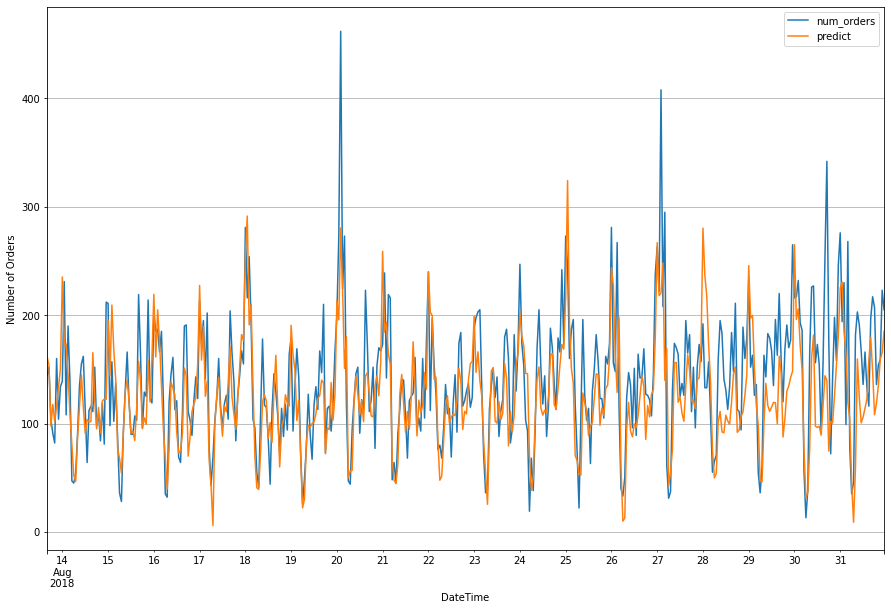

In [32]:
# prediction graph along with real values
df = pd.DataFrame(target_test)
df['predict'] = target_pred
fig = plt.figure(figsize=(15, 10))
ax = fig.gca()
df.plot(ax=ax)
plt.xlabel('DateTime')
plt.ylabel("Number of Orders")
plt.grid()
plt.show()

### Conclusion
The input data consisted of a dataset "Sweet Life Taxi" about taxi orders at airports. The data has been processed and prepared for training.

During the analysis, it was revealed that the trend in demand for taxis increases over time, and the seasonality is one day.

It was decided to test six ML algorithms: LinearRegressor, RandomForestRegressor, RidgeRegression, CatBoostRegressor, LGBMRegressor, XGBoostRegressor. The best hyperparameters were selected for each model using Cross-Validation.

According to the test results on the test sample, the best model was CatBoostRegressor with hyperparameters: loss_function='RMSE', iterations=200, learning_rate=0.4, and RMSE on the test = 43.515